# Training the model

In [1]:
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
        #print(os.path.join(dirname, filename))


In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

#progress bar
from tqdm import trange
from tqdm import tqdm

In [3]:
torch.set_default_dtype(torch.float64)
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

(True, True, 1, 0)

In [4]:
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Loading and preparing data

In [5]:
# Load and filter data
data = pd.read_csv("/kaggle/input/airbnbdata-barcelona/listing_data.csv")
data = data.select_dtypes(exclude=['object', 'string'])
data = data.drop("id", axis=1)

# Define target column
target_clm = "price"

# Drop rows with missing target
data = data.dropna(subset=[target_clm])

# Create an imputer that fills NaNs with the mean of each column
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on your data and transform it
data_imputed = imputer.fit_transform(data)

# Convert back to DataFrame to keep column names
data = pd.DataFrame(data_imputed, columns=data.columns)  

In [6]:
test_size = 0.2
train_df, test_df = train_test_split(data, test_size=test_size, random_state=42)

# Normalization stats from training data
train_mean = train_df.drop(target_clm, axis=1).mean().astype(np.float32).values
train_std = train_df.drop(target_clm, axis=1).std().replace(0, 1).astype(np.float32).values


## Dataset

In [7]:
class TabularDataset(Dataset):
    def __init__(self, df, target_clm, mean=None, std=None, normalize=True):
        self.X = df.drop(target_clm, axis=1).to_numpy(dtype=np.float32)
        self.y = df[target_clm].to_numpy(dtype=np.float32)
        self.mean = mean
        self.std = std
        self.normalize = normalize

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.normalize and self.mean is not None and self.std is not None:
            x = (x - self.mean) / self.std
        return torch.tensor(x, dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


In [8]:
# Datasets
train_dataset_full = TabularDataset(train_df, target_clm, train_mean, train_std, normalize=True)
test_dataset = TabularDataset(test_df, target_clm, train_mean, train_std, normalize=True)

# Split train/val
torch.manual_seed(0)
val_ratio = 0.1
train_dataset, val_dataset = random_split(train_dataset_full, [1 - val_ratio, val_ratio])

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



In [9]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x).squeeze()  # Squeeze to match target shape


In [10]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
input_dim = train_df.drop(target_clm, axis=1).shape[1]
model = LinearRegressionModel(input_dim).to(device)
model = model.float()
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [11]:
print("Any NaN in features? ", np.isnan(data.drop(target_clm, axis=1).to_numpy()).any())
print("Any NaN in target? ", np.isnan(data[target_clm].to_numpy()).any())

Any NaN in features?  False
Any NaN in target?  False


In [12]:
def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    model.train()
    train_loss = 0.0
    for batch in dataloader:
        X, y = batch
        X, y = X.to(device), y.to(device)

        #Forward pass
        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)

        #Backward pass
        loss.backward()
        optimizer.step()

        #calculate step quality
        train_loss += loss.item()

        master_bar.set_description(f"Epoch {master_bar.n + 1} (Train)")
        master_bar.set_postfix(loss=f"{loss.item():.3f}")

    return train_loss / len(dataloader)

        

In [13]:
def validate(dataloader, model, loss_fn, device, master_bar):
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X, y = X.to(device), y.to(device)

            #validate
            outputs = model(X)
            loss = loss_fn(outputs, y)
            val_loss += loss.item()

            master_bar.set_description(f"Epoch {master_bar.n + 1} (Validate)")
            master_bar.set_postfix(loss=f"{loss.item():.3f}")
    
    return val_loss / len(dataloader)

In [14]:
def run_training(model, optimizer, loss_function, device, num_epochs, train_dataloader, val_dataloader):
    train_losses = []
    val_losses = []

    master_bar = trange(num_epochs, desc="Training Epochs")
    for epoch in master_bar:
        train_loss = train(train_dataloader, optimizer, model, loss_function, device, master_bar)
        val_loss = validate(val_dataloader, model, loss_function, device, master_bar)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

In [15]:
def evaluate_model(model, dataloader, device):
    model.eval()
    model.to(device)
    absolute_errors = []

    with torch.no_grad():
        for batch in dataloader:
            # Assumes batch is (inputs, targets)
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            predictions = model(inputs)
            abs_errors = abs(predictions - targets)
            
            absolute_errors.extend(abs_errors.cpu().numpy())

    return np.array(absolute_errors)

In [16]:
def plot_accuracy(errors, bins = 10, min_range = None, max_range = None):

    if min_range is None:
        min_range = min(errors)
    if max_range is None:
        max_range = max(errors)

    counts, bin_edges = np.histogram(errors, bins=bins, range=(min_range, max_range))

    percentages = 100 * counts / counts.sum()

    bin_widths = bin_edges[1:] - bin_edges[:-1]

    plt.bar(bin_edges[:-1], percentages, width = bin_widths, align = 'edge', edgecolor='black')
    plt.xlabel("Absolute Error")
    plt.ylabel("Percentage (%)")
    plt.title("Percentage Distribution of Absolute Errors")
    
    #plt.hist(errors, bins, range=(min_range, max_range), density=True)
    plt.grid(True)
    plt.show() 

In [17]:
epochs=30

run_training(model, optimizer, criterion, device, epochs, train_loader, val_loader)



Epoch 30 (Validate): 100%|██████████| 30/30 [00:33<00:00,  1.12s/it, loss=20148.656]


([98187.31823508523,
  95730.27414772728,
  94238.40447443182,
  92570.79653764205,
  91405.28625710227,
  90781.19638671874,
  89387.10639204546,
  88890.80958806818,
  87850.16787109376,
  87216.86732066762,
  86381.19244495739,
  86286.57353515625,
  85523.41254438921,
  84729.20263671875,
  84093.43100142045,
  83555.15596590909,
  83207.73271484375,
  82642.01211825284,
  82212.97687322443,
  81738.07708629261,
  81719.76941583806,
  80998.99610262785,
  80546.19159268466,
  80235.50479403409,
  79812.21560724432,
  79433.25691583806,
  83997.52802734375,
  78761.73286576704,
  78556.04343927557,
  78081.6126065341],
 [114213.56512920673,
  114612.86899038461,
  115798.93719951923,
  117592.99812199519,
  120083.857421875,
  123173.25826322116,
  126820.61989182692,
  131142.53740985578,
  135934.26690204328,
  141173.73121995194,
  147023.44921875,
  153389.0390625,
  160274.37387319712,
  167492.27373798078,
  175276.4696514423,
  183595.66233473556,
  192378.22220552884,
  2017

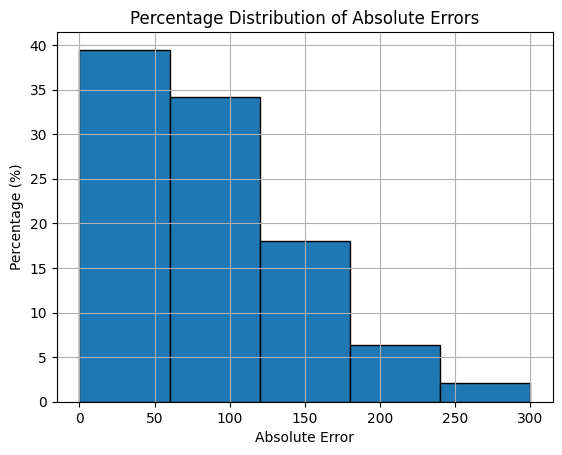

In [18]:
#evaluate
err = evaluate_model(model, test_loader, device)
plot_accuracy(err, bins = 5, min_range = 0, max_range = 300)

Epoch 30 (Validate): 100%|██████████| 30/30 [00:33<00:00,  1.10s/it, loss=19701.113]


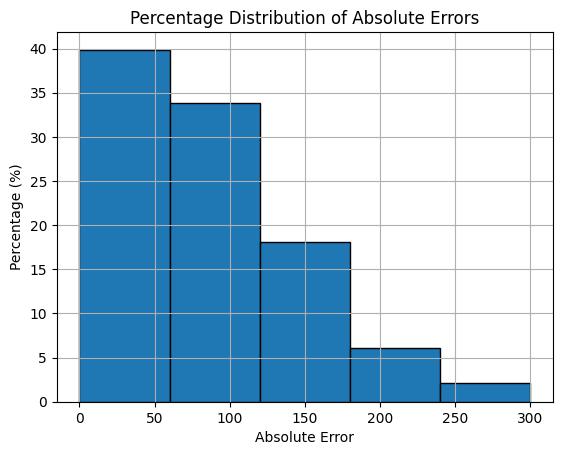

In [19]:
#Testing other optimizers (Adagrad is very efficient for our sparse data)
optimizer = torch.optim.Adagrad(model.parameters())
epochs=30

run_training(model, optimizer, criterion, device, epochs, train_loader, val_loader)
err = evaluate_model(model, test_loader, device)
plot_accuracy(err, bins = 5, min_range = 0, max_range = 300)

## Training utility

In [20]:
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        
        preds = model(X_batch)
        loss = criterion(preds, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val = X_val.to(device).float()
            y_val = y_val.to(device).float()

            val_preds = model(X_val)
            val_loss += criterion(val_preds, y_val).item()

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")


Epoch 01 | Train Loss: 77406.8314 | Val Loss: 365807.2603
Epoch 02 | Train Loss: 77518.8495 | Val Loss: 366093.0578
Epoch 03 | Train Loss: 77358.0857 | Val Loss: 366371.6540
Epoch 04 | Train Loss: 77999.1708 | Val Loss: 366650.9295
Epoch 05 | Train Loss: 77390.3302 | Val Loss: 366922.0513
Epoch 06 | Train Loss: 77560.8815 | Val Loss: 367190.3878
Epoch 07 | Train Loss: 77329.5689 | Val Loss: 367454.7973
Epoch 08 | Train Loss: 77351.1258 | Val Loss: 367716.7776
Epoch 09 | Train Loss: 77335.1413 | Val Loss: 367975.2539
Epoch 10 | Train Loss: 77328.3270 | Val Loss: 368229.7918
Epoch 11 | Train Loss: 77300.2629 | Val Loss: 368482.1080
Epoch 12 | Train Loss: 77350.4804 | Val Loss: 368733.1086
Epoch 13 | Train Loss: 77322.2132 | Val Loss: 368979.6148
Epoch 14 | Train Loss: 77317.8193 | Val Loss: 369223.5213
Epoch 15 | Train Loss: 77381.3709 | Val Loss: 369465.3678
Epoch 16 | Train Loss: 77409.8088 | Val Loss: 369704.0172
Epoch 17 | Train Loss: 77318.7943 | Val Loss: 369939.9422
Epoch 18 | Tra